# Analyzing a Time Series of the Thames River in Python


_Note: You can consult the solution of this live training in the file browser as `notebook-solution.ipynb`_

Time series data is everywhere, from watching your stock portfolio to monitoring climate change, and even live-tracking as local cases of a virus become a global pandemic. In this live code-along, you’ll work with a time series that tracks the tide levels of the Thames River. You’ll first load the data and inspect it data visually, and then perform calculations on the dataset to generate some summary statistics. Next, you’ll decompose the time series into its component attributes. You’ll end with a taster of autocorrelation: a first step in time series forecasting.

The original dataset is available from the British Oceanographic Data Center [here](https://www.bodc.ac.uk/data/published_data_library/catalogue/10.5285/b66afb2c-cd53-7de9-e053-6c86abc0d251) and you can read all about this fascinating archival story in [this article](https://www.nature.com/articles/s41597-022-01223-7) from the Nature journal.

Here's a map of the locations of the tidal gauges along the River Thames in London.

![](locations.png)

In [1]:
# Package imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Task 1: Read one file to explore the data format and prepare the data for analysis.

The dataset consists of 13 .txt files, containing comma separated data. Navigate to the "Browse and Upload Files" tab in the toolbar on the right to see the data in a folder called `Data/`. We'll begin by analyzing one of these files and preparing it for analysis. We can then create a helper function in case you are interested in analyzing other data later. 

The dataset comes with a file called `Data_description.pdf`. 

| Variable Name | Description | Format |
| ------------- | ----------- | ------ |
| Date and time | Date and time of measurement to GMT. Note the tide gauge is accurate to one minute. | dd/mm/yyyy hh:mm:ss |
| Water level | High or low water level measured by tide gauge. Tide gauges are accurate to 1 centimetre. | metres (Admiralty Chart Datum (CD), Ordnance Datum Newlyn (ODN or Trinity High Water (THW)) | 
| Flag | High water flag = 1, low water flag = 0 | Categorical (0 or 1) |

Let's begin by loading the London Bridge data. When loading time series data, always look out for the time zone the data is provided in. Sometimes, your data might be provided in UTC, and will need to be converted to local time if you want to do local analysis. Fortunately, the description above tells us the data is in GMT, which is the same as coordinated universal time (UTC).

### Instructions

- Use pandas to read the London Bridge dataset from the CSV file named `Data/10-11_London_Bridge.txt` and assign it to the variable `lb`.
- Display `lb`.

In [3]:
lb = pd.read_csv('Data/10-11_London_Bridge.txt')
lb

,Date and time,water level (m ODN),flag,HW=1 or LW=0
0,01/05/1911 15:40:00,3.7130,1,NaN
1,02/05/1911 11:25:00,-2.9415,0,NaN
2,02/05/1911 16:05:00,3.3828,1,NaN
3,03/05/1911 11:50:00,-2.6367,0,NaN
4,03/05/1911 16:55:00,2.9256,1,NaN
...,...,...,...,...
115498,30/12/1995 20:44:00,3.2900,1,NaN
115499,31/12/1995 02:32:00,-1.6000,0,NaN
115500,31/12/1995 08:59:00,3.2000,1,NaN
115501,31/12/1995 15:03:00,-1.8000,0,NaN


Since one of the column headings in the csv file had a comma (`"flag, HW=1 or LW=0"`), `pd.read_csv` has created an extra, empty column. We'll need to drop this extra column and rename our column headings. Shorter and more memorable column names will facilitate our analysis later on.

### Instructions
- Call `lb.info()` or `lb.describe()` to confirm that the last column is empty and contains no data.
- Create a new DataFrame `df` which takes only the first three columns and rename them as `datetime`, `water_level`, and `is_high_tide`, respectively. 

In [4]:
lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115503 entries, 0 to 115502
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date and time         115503 non-null  object 
 1    water level (m ODN)  115503 non-null  object 
 2    flag                 115503 non-null  int64  
 3    HW=1 or LW=0         0 non-null       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.5+ MB


In [5]:
df = lb[lb.columns[0:3]]
df.columns = ['datetime','water_level','is_high_tide']

Calling `lb.info()` above showed us both the `datetime` and `water_level` columns are of type `object`. We'll convert these to `datetime` and `water_level`, respectively. We'll also add two columns, `month` and `year`, which we'll need to access later on.

### Instructions
- Use `pd.to_datetime()` to convert the `datetime` column to the `datetime` format. Since the dataset is large, this step can take a few seconds.
- Use `.astype(float)` to convert the `water_level` column to the `float` format.

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['water_level'] = df['water_level'].astype(float)

In [7]:
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

Before moving on to conduct analysis, let's define a helper function for data cleaning so we don't have to do this each time. The function takes a `DataFrame` (which we'll read from our `.txt` files), renames the columns, formats the `datetime` column, and converts `water_level` to a `float` data type.

In [8]:
def clean_data(data):
    
    data = data[data.columns[0:3]]
    data.columns = ['datetime','water_level','is_high_tide']
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['water_level'] = data['water_level'].astype(float)
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year
    
    return data
clean_data(lb)

,datetime,water_level,is_high_tide,month,year
0,1911-01-05 15:40:00,3.7130,1,1,1911
1,1911-02-05 11:25:00,-2.9415,0,2,1911
2,1911-02-05 16:05:00,3.3828,1,2,1911
3,1911-03-05 11:50:00,-2.6367,0,3,1911
4,1911-03-05 16:55:00,2.9256,1,3,1911
...,...,...,...,...,...
115498,1995-12-30 20:44:00,3.2900,1,12,1995
115499,1995-12-31 02:32:00,-1.6000,0,12,1995
115500,1995-12-31 08:59:00,3.2000,1,12,1995
115501,1995-12-31 15:03:00,-1.8000,0,12,1995


## Task 2. Analyze the London Bridge data to get a sense of the water level.

Let's begin analyzing the data with a `displot()` or `hist` of `water_level`. This plot shows that the data is bimodal, meaning it has two separate peaks. When we plot the data with `is_high_tide=0 `and `is_high_tide=1`, separately we get two approximately normal distributions, with separate means and variances. Moving forward, we'll analyze low tide and high tide data separately.

### Instructions
- Create a `hist` of `df` where `is_high_tide=0`.
- Create a `hist` of `df` where `is_high_tide=1`.
- Call `plt.show()`.

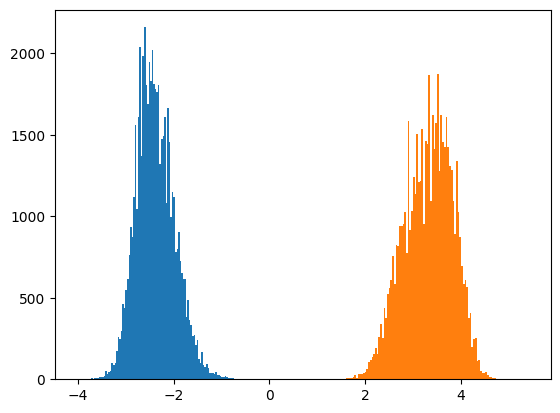

In [12]:
plt.hist(df.query('is_high_tide==0')['water_level'],bins=150)
plt.hist(df.query('is_high_tide==1')['water_level'],bins=150)
plt.show()

Boxplots will give us a sense of the min, max, range, and outliers of the data. We'll create these separately for high tide and low tide. By default, the whiskers of the boxplot will show us 1.5 * the interquartile range.

### Instructions
- Create a boxplot of `df` where `is_high_tide==0`.
- Create a boxplot of `df` where `is_high_tide==1`.

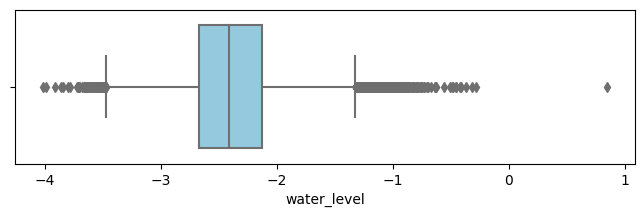

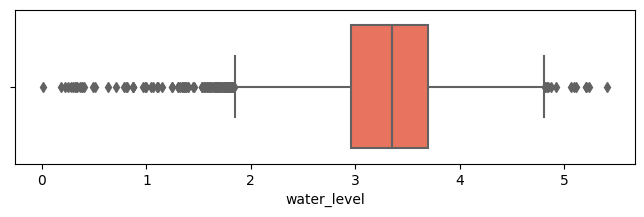

In [13]:
plt.figure(figsize=(8,2))
sns.boxplot(data=df.query('is_high_tide==0'),x='water_level',color='SkyBlue')
plt.show()

plt.figure(figsize=(8,2))
sns.boxplot(data=df.query('is_high_tide==1'),x='water_level',color='Tomato')
plt.show()

We can use the information gathered from our boxplots and summary statistics to count the number of days London Bridge has had high tide over the last 84 years.

### Instructions
- Use `.describe()` to summarize `water_level` where `is_high_tide==1`.
- Count the number of days of data of high tide per year in `df`.
- Count the number of days of data where water level was above the 75th percentile in `df`.

In [29]:
df.query('is_high_tide==1').describe()

,water_level,is_high_tide,month,year
count,57909.000000,57917.0,57917.000000,57917.000000
mean,3.318373,1.0,6.534126,1953.701400
std,0.509422,0.0,3.441167,24.334694
min,0.010000,1.0,1.000000,1911.000000
25%,2.956400,1.0,4.000000,1933.000000
50%,3.352600,1.0,7.000000,1954.000000
75%,3.700000,1.0,10.000000,1975.000000
max,5.409900,1.0,12.000000,1995.000000


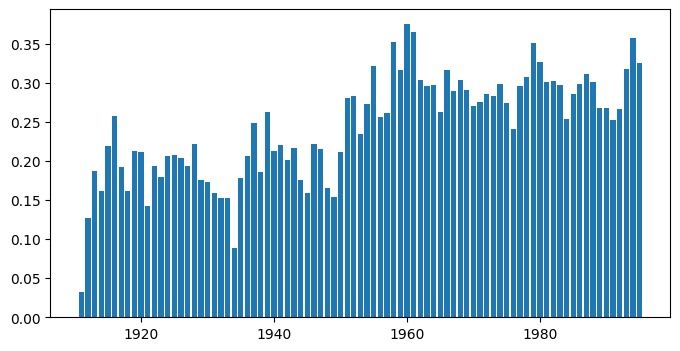

In [38]:
variable = 3.7

plt.figure(figsize=(8,4))
all_days = df.query('is_high_tide==1').groupby('year').count()['is_high_tide']
high_days = df.query(f'(is_high_tide==1) & (water_level>{variable})').groupby('year').count()['is_high_tide']
ratio = (high_days/all_days).reset_index()
plt.bar(ratio.year,ratio.is_high_tide)
plt.show()

Write your interpretation here.

### Instructions
- Use `.describe()` to summarize `water_level` where `is_high_tide==0`.
- Count the number of days of low tide we have per year in `df`.
- Count the number of days of low tide data where water level was below the 25th percentile in `df`.

In [39]:
df.query('(is_high_tide==0)').describe()

,water_level,is_high_tide,month,year
count,57580.000000,57586.0,57586.000000,57586.000000
mean,-2.383737,0.0,6.532491,1953.671708
std,0.399748,0.0,3.444258,24.366551
min,-4.013000,0.0,1.000000,1911.000000
25%,-2.666900,0.0,4.000000,1933.000000
50%,-2.412900,0.0,7.000000,1954.000000
75%,-2.128700,0.0,10.000000,1975.000000
max,0.842900,0.0,12.000000,1995.000000


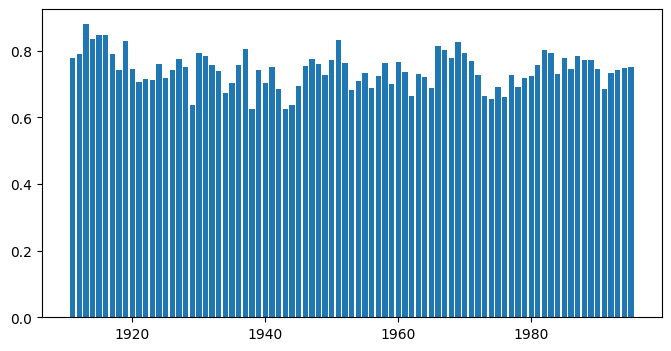

In [41]:
variable = -2.66

plt.figure(figsize=(8,4))
all_days = df.query('is_high_tide==0').groupby('year').count()['is_high_tide']
high_days = df.query(f'(is_high_tide==0) & (water_level>{variable})').groupby('year').count()['is_high_tide']
ratio = (high_days/all_days).reset_index()
plt.bar(ratio.year,ratio.is_high_tide)
plt.show()

Write your interpretation here.

## Task 3. Assess monthly trends in water level for 1927, 1928 and 1929.

### Instructions
- Create an empty DataFrame.
- Loop through an array of years 1927, 1928 and 1929.
- For each year, group the data by `is_high_tide` and resample by `1M`, calculating the `median`.
- Plot the high tide data for these months, with a horizontal line indicating the median of high tide data in these months.
- Plot the low tide data for these months, with a horizontal line indicating the median of low tide data in these months.

In [43]:
water_level = pd.DataFrame()

for year in [1927, 1928, 1929]:
    level_per_year = df.query(f'year=={year}').set_index('datetime')
    level_per_year = level_per_year.groupby('is_high_tide').resample('1M').median()['water_level'].reset_index()
    level_per_year['month'] = level_per_year.datetime.dt.month
    level_per_year['year'] = level_per_year.datetime.dt.year  
    water_level = pd.concat([water_level,level_per_year]).reset_index(drop=True)

In [44]:
water_level

,is_high_tide,datetime,water_level,month,year
0,0,1927-01-31,-2.3700,1,1927
1,0,1927-02-28,-2.3827,2,1927
2,0,1927-03-31,-2.4081,3,1927
3,0,1927-04-30,-2.4589,4,1927
4,0,1927-05-31,-2.5351,5,1927
...,...,...,...,...,...
67,1,1929-08-31,3.1161,8,1929
68,1,1929-09-30,3.2304,9,1929
69,1,1929-10-31,3.3574,10,1929
70,1,1929-11-30,3.4590,11,1929


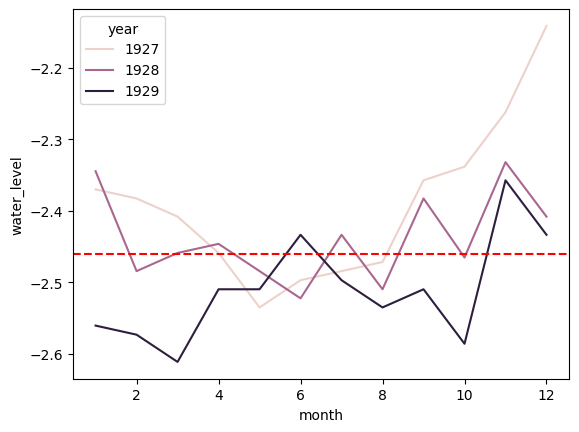

In [46]:
sns.lineplot(data=water_level[water_level['is_high_tide']==0],
            y='water_level',x='month',hue='year')
plt.axhline(-2.46,0,12,linestyle='--',color='red')
plt.show()

How might you interpret this graph?

How might you interpret this graph?

## Task 4. Beginning a forecasting model for London Bridge: a taste of autocorrelation.

When looking at the **high tide levels** for a sample of the data, it appears to have some monthly peaks and troughs.

We can compute a metric called autocorrelation to quantify this repeating pattern. We find that autocorrelation is highest at 15 days (waxing and waning of the moon).

### Instructions
- Plot the high tide data for `df28`.
- Compute the autocorrelation of `df28` at yearly, monthly, biweekly and daily frequencies.

## Where to next?
- Autocorrelation is the first step in building a time series model. To learn more about time series forecasting, check out our course on [Time Series Analysis in Python](https://app.datacamp.com/learn/courses/time-series-analysis-in-python).
- To learn more about visualizing time series data, check out [Visualizing Time Series Data in Python](https://app.datacamp.com/learn/courses/visualizing-time-series-data-in-python).
- To get started from scratch, visit our [Time Series in Python](https://app.datacamp.com/learn/skill-tracks/time-series-with-python) track.